In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [16]:
sql = '''SELECT vehicle AS "Vehicle ID", message_datetime::DATE AS "Date", 
100.0*SUM(CASE WHEN s.geom IS NOT NULL THEN 1 ELSE 0 END)/ COUNT(1)
 AS "% Points Downtown", 
 COUNT(1) AS "Num points"
  FROM ttc.cis_2017 c
  LEFT OUTER JOIN rdumas.downtown_streetcars s ON ST_Within("position", s.geom)
  WHERE vehicle = 4443 AND route IN (514,504)
  GROUP BY "Vehicle ID", "Date" ORDER BY "Date"'''
streetcar_over_time_4443 = pandasql.read_sql(sql, con)

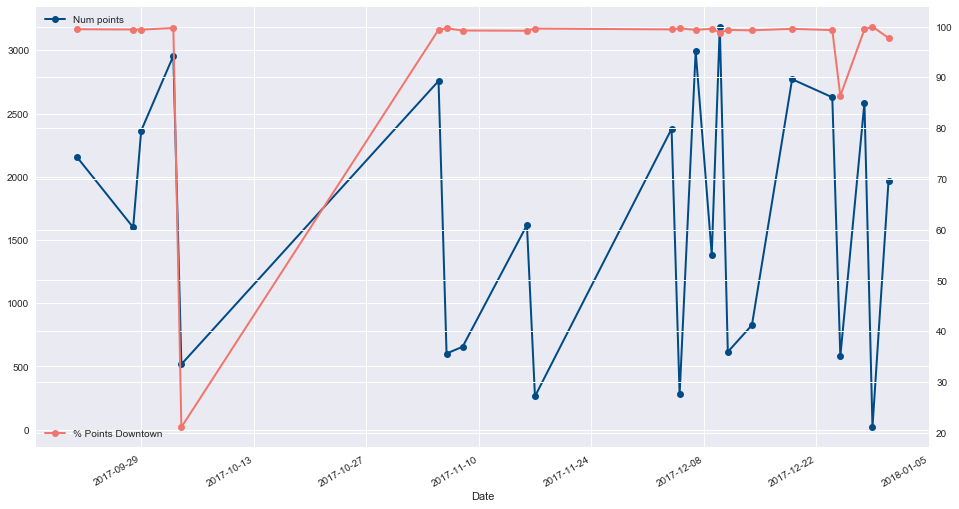

In [20]:
fig, ax1 = plt.subplots(1,1, figsize=(16,9))

colors=['#004B85','#F2756D']

ax2 = ax1.twinx()
streetcar_over_time_4443.plot(x='Date',
                     y="Num points",
                     ax=ax1,
                     linewidth=2,
                              marker='o',
                     color=colors[0])
streetcar_over_time_4443.plot(x='Date',
                     y="% Points Downtown",
                     ax=ax2,
                     linewidth=2,
                     marker='o',
                     color=colors[1])
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.gcf().autofmt_xdate()

It seems October 4th is an outlier for reliability for this streetcar. What about streetcars overall?

In [3]:
sql = '''SELECT CASE WHEN vehicle BETWEEN 4000 AND 4200 THEN 'CLRV'
WHEN vehicle BETWEEN 4200 AND 4300 THEN 'ALRV'
WHEN vehicle BETWEEN 4400 AND 4500 THEN 'Flexity Freedom'
ELSE 'Bus Series '|| LEFT(vehicle::TEXT, 1) || 'XXX'
END AS "Vehicle Series", message_datetime::DATE AS "Date", 
100.0*SUM(CASE WHEN s.geom IS NOT NULL THEN 1 ELSE 0 END)/ COUNT(1)
 AS "% Points Downtown", 
 COUNT(1) AS "Num points"
  FROM ttc.cis_2017 c
  LEFT OUTER JOIN rdumas.downtown_streetcars s ON ST_Within("position", s.geom)
  WHERE route IN (514,504) AND message_datetime >= '2017-10-01'
  GROUP BY "Vehicle Series", "Date" ORDER BY "Date", "Vehicle Series"'''
position_accuracy_over_time = pandasql.read_sql(sql, con)

In [4]:
position_accuracy_over_time.to_pickle('position_accuracy_over_time.pkl')

In [5]:
position_accuracy_over_time["Vehicle Series"].unique()

array(['ALRV', 'CLRV', 'Flexity Freedom', 'Bus Series 7XXX',
       'Bus Series 8XXX', 'Bus Series 1XXX'], dtype=object)

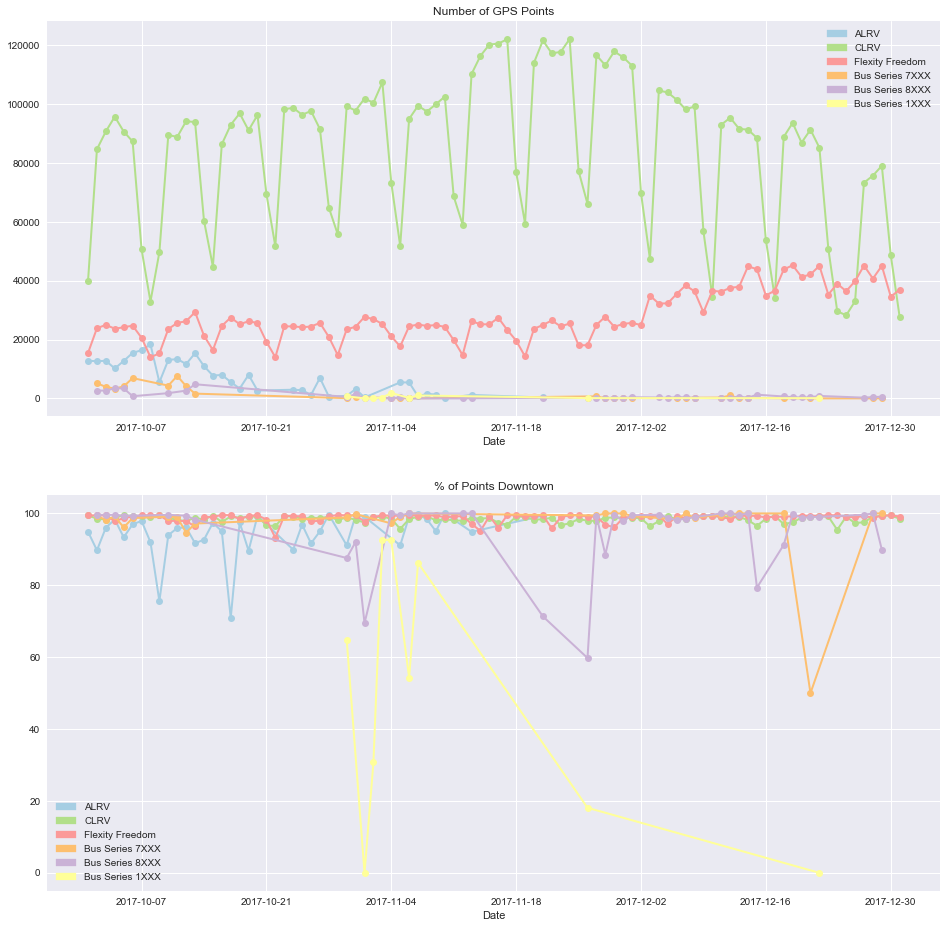

In [8]:
color_map = plt.get_cmap('Paired')
fig, axes = plt.subplots(2,1, figsize=(16,16))
num_colors = 6
colors = [color_map(1.*i/num_colors) for i in range(num_colors)]

handles, labels = [], []

for idx, vehicle in enumerate(position_accuracy_over_time['Vehicle Series'].unique()):
    filtered = position_accuracy_over_time[position_accuracy_over_time['Vehicle Series']==vehicle]
    filtered.plot(x='Date',
                  y="Num points",
                  ax=axes[0],
                  linewidth=2,
                  marker='o',
                  color=colors[idx])
    filtered.plot(x='Date',
                  y="% Points Downtown",
                  ax=axes[1],
                  linewidth=2,
                  marker='o',
                  color=colors[idx])
    handles.append(mpl.patches.Patch(color=colors[idx],label=vehicle))

axes[0].set_title('Number of GPS Points')
axes[1].set_title('% of Points Downtown')
for ax in axes:
    ax.legend(handles=handles)

Overall performance seems pretty good, in particular for the Flexity Freedoms.
The 1XXX buses do not perform very well. And the Articulated LRVs seem to have a couple of bad days which are worth further investigation. Ditto for a few days for Bus Series 8XXX and 7XXX